# Note
--- v4 update ---
Adjust many cell, take some nice idea from Li

--- v3 archive ---
Hi Reviewer,

Thanks for your time to review my capestone project. I want to make some note at top to save your time on review my project.

- structure
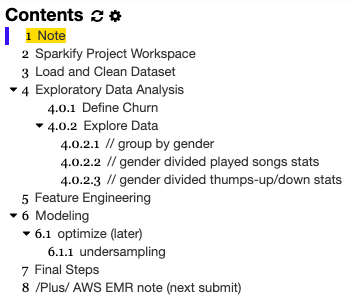

- request for coaching
    - **Q1:How to practice Sprak at real world?** I am new to spark, I manage about 3 week to finish this project, and still get some unclear on part of it. So where can I get some real big data to explore the skill of spark (on AWS, not local). Can you share something?
    - **Q2:Spark vs Flink** I do some research that both Spark and Flink are super-stars nowadays. While Spark come from batch to stream, and Flink come from stream to batch. How shoud I choose from them. Or for the short, what are the pro and cons for Spark and Flink on differed situation?
    
- notice
    - data file: for the git limit < 100MB, I use a compressed file to complete(also the same with 128MB at local, if you want to r

- version 
    - version1 - 
    - version2 - finish uda workplace run out.
    - version3 - finish local run out. (mac env)
    - version4 - (finished at next submit) - aws emr run out, and take a new chaper at the end `/Plus/ AWS EMR note`
    
Thanks a lot again, waiting for you reply.
Meng

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
# spark env check（mac）
# java check
!java -version
# 如果不是 1.8 需要
## 关掉jupyter notebook，之后在terminal运行
## export JAVA_HOME=`/usr/libexec/java_home -v 1.8.0_212`
## 如果版本号不对（小版本可能会升级）需要查询 /usr/libexec/java_home -V
## 完成后再次检查版本，输出为类似 java version "1.8.0_212"

# pyspark check
## pyspark 有时需要调整小版本比如从 2.44 - 2.32
## 直接 conda install 就可以变更
## conda install pyspark=2.3
!conda list|grep pyspark

java version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b10)
Java HotSpot(TM) 64-Bit Server VM (build 25.212-b10, mixed mode)
pyspark                   2.3.2                    py36_0  


In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import re

In [5]:
# create a Spark session
spark = SparkSession.builder.appName('sparky').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

- 开始使用 mac air 处理 bz2 发现很慢，但其实是数据经过修改的原因
    - 之前是用 pandas 抽出 10% 的数据，但用 pandas 压缩之后有问题
    - 使用操作系统的压缩就OK的，而且压缩率高很多（同一格式）
    - 数据抽取代码归档如下。压缩问题后续再linux工业化时候再测试
    - 可能和Pyspark的读入参数有关，课程中的说明：
        - Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
        - Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
        - PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json
    
```python
## smaller
pddf_small = pddf.sample(frac=0.1)
display(pddf_small.size)
display(pddf_small.head(1))

## new file name
newfile = '10pre_' + file
print(newfile)

## persistence compression
pddf_small.to_json(newfile,compression='bz2')

## persistence normal
pddf_small.to_json('10pre_mini_sparkify_event_data.json')
```

In [6]:
# read df to spark
## beware of to choose approate file
file_ori = 'mini_sparkify_event_data.json.bz2'
df = spark.read.json(file_ori)
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
# clean df
## na/dup
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
## NaN user
df_clean = df_clean.filter(df["userId"] != "")
## count
df_clean.count(),df.count(),df.count()-df_clean.count()

(278154, 286500, 8346)

In [8]:
from pyspark import StorageLevel
# df check sample
print('--- persisit ---')
display(df_clean.persist(StorageLevel.MEMORY_ONLY))
## cache 和 persist 都是对 spark 存储的操作
## cache 是默认（RDD在MEM，DataFrame在MEM+Disk）
## 区别说明 https://stackoverflow.com/questions/26870537/what-is-the-difference-between-cache-and-persist
## Leverl可选文档 https://www.tutorialspoint.com/pyspark/pyspark_storagelevel.htm
print('--- userId ---')
display(df_clean.select("userId").sort("userId").show(5))
print('--- sessionId ---')
display(df_clean.select("sessionId").sort("userId").show(5))

--- persisit ---


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

--- userId ---
+------+
|userId|
+------+
|    10|
|    10|
|    10|
|    10|
|    10|
+------+
only showing top 5 rows



None

--- sessionId ---
+---------+
|sessionId|
+---------+
|      595|
|      595|
|      595|
|      595|
|      595|
+---------+
only showing top 5 rows



None

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## / Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

## / Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# check all data
display(df_clean.head(1))
## .show 的输出在jupyter 特别不友好，列多的话很难读
## .head 又没有table样式的输出

[Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78')]

In [10]:
## 挑选比较重要的列展示
## 从数据看 page 记录的是当听歌的时候用户都点击了什么
df_clean.select(["page","artist",'song','level','userId']).show(10)

+-----------+---------------+-------------------+-----+------+
|       page|         artist|               song|level|userId|
+-----------+---------------+-------------------+-----+------+
|   NextSong|The Futureheads|              Robot| free|    78|
|Thumbs Down|           null|               null| free|    78|
|   NextSong|O'Rosko Raricim|      Terre Promise| paid|    25|
|   NextSong|    Morgan Page|  Strange Condition| paid|    15|
|       Home|           null|               null| free|    27|
|   NextSong|         Corona|Rhythm Of The Night| paid|    51|
|   NextSong|   Taylor Swift| You Belong With Me| free|    93|
|   NextSong|   Martin Jondo|    All I Ever Know| paid|    81|
|       Home|           null|               null| paid|    54|
|   NextSong|     Slim Dusty|    Long Black Road| free|    53|
+-----------+---------------+-------------------+-----+------+
only showing top 10 rows



In [11]:
# dorpDuplicates 用法是对所有选中列进行的。对比下这3个
## 好像pandas不是这样的，后续测试下
display(df_clean.select(["page","userId",'gender']).dropDuplicates().show())
display(df_clean.select(['gender',"page","userId"]).dropDuplicates().show())
display(df_clean.select(['gender',"page"]).dropDuplicates().show())

+---------------+------+------+
|           page|userId|gender|
+---------------+------+------+
|       NextSong|   127|     F|
|           Home|    77|     F|
|      Thumbs Up|200018|     M|
|      Downgrade|    60|     M|
|         Logout|300025|     M|
|    Roll Advert|100013|     F|
|      Thumbs Up|300006|     M|
|    Roll Advert|   137|     M|
|      Downgrade|300009|     F|
|           Help|    56|     M|
|    Thumbs Down|300015|     M|
|    Roll Advert|   150|     M|
|        Upgrade|    55|     M|
|       NextSong|   107|     F|
|     Add Friend|    15|     M|
|Add to Playlist|   111|     F|
|    Roll Advert|    79|     M|
|       Settings|    98|     M|
|    Thumbs Down|    13|     F|
|    Thumbs Down|   147|     M|
+---------------+------+------+
only showing top 20 rows



None

+------+---------------+------+
|gender|           page|userId|
+------+---------------+------+
|     F|       NextSong|    80|
|     M|       NextSong|200009|
|     M|           Home|   138|
|     F|       NextSong|   143|
|     F|      Thumbs Up|300009|
|     M|    Roll Advert|200014|
|     F|      Thumbs Up|100010|
|     M|    Roll Advert|   123|
|     M|           Help|300006|
|     M|         Logout|   149|
|     M|        Upgrade|100005|
|     M|    Roll Advert|   129|
|     M|       NextSong|   121|
|     F|Add to Playlist|   124|
|     M|       NextSong|200011|
|     M|       NextSong|    32|
|     F|    Thumbs Down|    20|
|     M|           Home|    59|
|     M|          About|   101|
|     F|    Thumbs Down|   120|
+------+---------------+------+
only showing top 20 rows



None

+------+----------------+
|gender|            page|
+------+----------------+
|     M|            Home|
|     F|           Error|
|     M|           Error|
|     M|        NextSong|
|     M|      Add Friend|
|     F|   Save Settings|
|     M|          Cancel|
|     M|          Logout|
|     M|     Roll Advert|
|     M|         Upgrade|
|     F|Submit Downgrade|
|     F|            Home|
|     M|            Help|
|     M|     Thumbs Down|
|     F|            Help|
|     F|       Downgrade|
|     F|      Add Friend|
|     F|        NextSong|
|     F|          Logout|
|     M| Add to Playlist|
+------+----------------+
only showing top 20 rows



None

In [12]:
# filter cancel user
## 检查下 Page 里的 Cancel 操作
display(df_clean.printSchema())
display(df_clean.select("page").dropDuplicates().show())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



None

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



None

In [13]:
## 使用 Cancellation Confirmation 来定义客户流失
cancel_user_df = df_clean.filter(df_clean.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cancel_user_list = [user["userId"] for user in cancel_user_df.collect()]
display(cancel_user_list[:10])

## create column for canceled or not user on category type
df_clean = df_clean.withColumn("cancel", df_clean.userId.isin(cancel_user_list))
df_clean.printSchema()

## 最后多一列‘cancel’就对了

['125', '51', '54', '100014', '101', '100021', '29', '73', '87', '3']

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- cancel: boolean (nullable = true)



### // group by gender

In [14]:
# group by gender
## 联合的看（看不到总数）
display(df_clean.dropDuplicates(['userId']).groupby(['gender','cancel']).count().show())
## 分开看
display(df_clean.dropDuplicates(['userId']).groupby(['gender']).count().show())
display(df_clean.dropDuplicates(['userId']).groupby(['cancel']).count().show())

+------+------+-----+
|gender|cancel|count|
+------+------+-----+
|     M|  true|   32|
|     F| false|   84|
|     F|  true|   20|
|     M| false|   89|
+------+------+-----+



None

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



None

+------+-----+
|cancel|count|
+------+-----+
|  true|   52|
| false|  173|
+------+-----+



None

### // gender divided played songs stats

In [15]:
# gender divided played songs stats
## 转成pandas再画图
pd_songs = df_clean.where(df_clean.song!='null').groupby(['cancel','userId']) \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('cancel').toPandas()

In [16]:
pd_songs.head()

,cancel,userId,SongsPlayed
0,False,114,1292
1,False,39,8002
2,False,200012,66
3,False,82,1705
4,False,14,1230


In [17]:
# 其实到用户来讲mini的数量真的很少
pd_songs.query('cancel == False').shape[0],pd_songs.query('cancel == True').shape[0]

(173, 52)

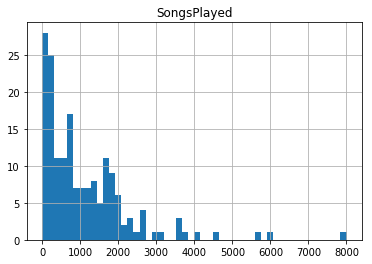

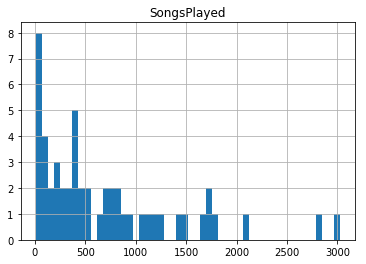

In [18]:
## 可以看出来取关的人听歌更少（x是听歌数量，y是出现次数）
pd_songs.groupby(['cancel']).hist(bins=50);

In [19]:
pd_songs['SongsPlayed'].value_counts()

650     3
377     2
429     2
178     2
1797    2
       ..
800     1
798     1
2841    1
280     1
2048    1
Name: SongsPlayed, Length: 212, dtype: int64

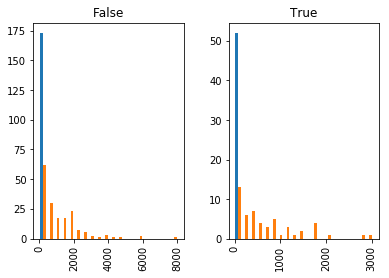

In [20]:
# 加个 by 可以按照 cancel False 和 True 画图（左和右）
## 图形颜色是把出现类别做多的画为不同颜色，和分类无关（想了好半天才想通）
pd_songs.hist(by='cancel',bins=20);

### // length statistic

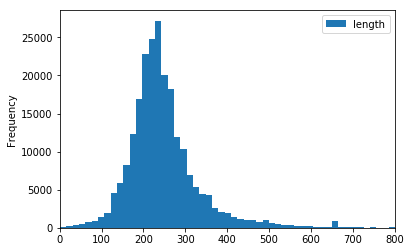

In [21]:
# idea form LK
pd_length = df_clean.select('length').toPandas()
pd_length.plot.hist(bins=200,xlim=(0,800));
## 终于对 xlim 下手了
## 注意由于 pandas 库的历史原因 DataFrame.hist 不支持xlim参数
## DataFrame.plot.hist 就可以

### // gender divided thumps-up/down stats

In [22]:
# gender divided thumps-up/down stats
pd_up = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('cancel').toPandas()
pd_down = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['cancel','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('cancel').toPandas()

print('ThumbsUps for people who stay',
      pd_up[pd_up['cancel']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',
      pd_up[pd_up['cancel']==True]['ThumbsUps'].mean())
print('ThumbsDowns for people who stay',
      pd_down[pd_down['cancel']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',
      pd_down[pd_down['cancel']==True]['ThumbsDowns'].mean())

ThumbsUps for people who stay 62.89411764705882
ThumbsUps for people who leave 37.18
ThumbsDowns for people who stay 13.225806451612904
ThumbsDowns for people who leave 10.333333333333334


In [23]:
pd_up.columns

Index(['cancel', 'userId', 'ThumbsUps'], dtype='object')

In [24]:
pd_up['cancel'].value_counts()

False    170
True      50
Name: cancel, dtype: int64

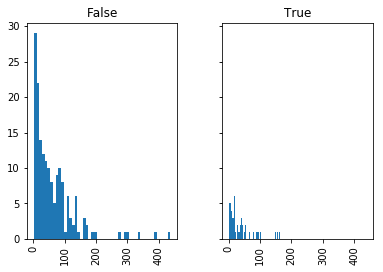

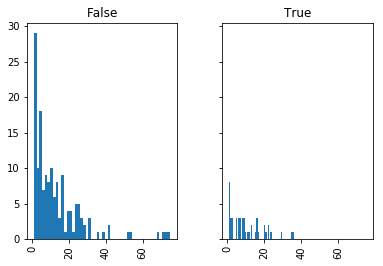

In [25]:
## visulize
pd_up.hist('ThumbsUps', by='cancel', bins=50, sharex=True, sharey=True);
pd_down.hist('ThumbsDowns', by='cancel', bins=50, sharex=True, sharey=True);

## sharex,sharey 是标记x和y的坐标相同，便于对比
## 尝试使用了下 .post.hist 限制x，结果 by 处报错，再研究
## 如果加上了 density=1 就是进行密度转换，后续研究

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## / Numeric Feature

In [26]:
# 'cancel' numeric
#Pass此节内容，后面在pipeline有indexer方法直接处理label
from pyspark.sql.functions import *

df_clean = df_clean.withColumn('cancel', when((df_clean.page == 'Cancellation Confirmation') | (df_clean.page == 'Downgrade'), 1 ).otherwise(0))

In [27]:
# feature1 gender
df_gender = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender = df_gender.withColumn('gender', df_gender.gender.cast("int"))

df_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
+------+------+
only showing top 10 rows



In [29]:
df_gender.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)



In [30]:
# feature2 played songs
df_songs = df_clean.where(df_clean.song!='null').groupby('userId') \
    .agg(count(df_clean.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])

df_songs.show(10)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
+------+-----------+
only showing top 10 rows



In [31]:
df_songs.show(10)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
+------+-----------+
only showing top 10 rows



In [32]:
df_songs.printSchema()

root
 |-- userId: string (nullable = true)
 |-- SongsPlayed: long (nullable = false)



In [33]:
# feature3 thumps up/down
df_thumbsup = df_clean.where(df_clean.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])
df_thumbsdown = df_clean.where(df_clean.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])

df_thumbsup.show(10),df_thumbsdown.show(10);

+------+---------+
|userId|ThumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
+------+---------+
only showing top 10 rows

+------+-----------+
|userId|ThumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
+------+-----------+
only showing top 10 rows



In [34]:
# feature4 singers number
df_singers = df_clean.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_clean.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])

df_singers.show(10)

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
+------+---------------+
only showing top 10 rows



## / Join Features

In [35]:
# join features
df_final = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','cancel'])
for feature in [df_gender, df_songs,df_thumbsup,df_thumbsdown,df_singers]:
    df_final = df_final.join(feature,'userId')
    
df_final.show(10)

+------+------+------+-----------+---------+-----------+---------------+
|userId|cancel|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+------+------+-----------+---------+-----------+---------------+
|    10|     0|     0|        673|       37|          4|            565|
|   100|     0|     0|       2682|      148|         27|           1705|
|100001|     0|     1|        133|        8|          2|            125|
|100004|     0|     1|        942|       35|         11|            733|
|100005|     0|     0|        154|        7|          3|            149|
|100006|     1|     1|         26|        2|          2|             26|
|100007|     0|     1|        423|       19|          6|            357|
|100008|     0|     1|        772|       37|          6|            623|
|100009|     0|     0|        518|       23|          8|            442|
|100010|     0|     1|        275|       17|          5|            252|
+------+------+------+-----------+---------+-------

In [36]:
df_final.show(10),df_final.printSchema()

+------+------+------+-----------+---------+-----------+---------------+
|userId|cancel|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+------+------+-----------+---------+-----------+---------------+
|    10|     0|     0|        673|       37|          4|            565|
|   100|     0|     0|       2682|      148|         27|           1705|
|100001|     0|     1|        133|        8|          2|            125|
|100004|     0|     1|        942|       35|         11|            733|
|100005|     0|     0|        154|        7|          3|            149|
|100006|     1|     1|         26|        2|          2|             26|
|100007|     0|     1|        423|       19|          6|            357|
|100008|     0|     1|        772|       37|          6|            623|
|100009|     0|     0|        518|       23|          8|            442|
|100010|     0|     1|        275|       17|          5|            252|
+------+------+------+-----------+---------+-------

(None, None)

## / Drop UserId (passed)

In [38]:
#df_final = df_finail.drop('userId')
#df_finail.printSchema()
## 不能drop userid 因为是id对应多操作的情况，否则无法有效聚合做分析

## / Persistence

In [39]:
### file persistence
## saving to csv
#file = 'mini_sparkify_event_data_final_4.csv'
#df_final.write.save(file, format="csv")
## header = True 是提醒数据是否带header的参数，写入和读取保持一致即可
## df_final.write.save(file_finail, format="json") 会报错
## 在spark2.3之后对json格式有要求，优先使用csv
## 写出来是一个目录，是因为spark是分布式处理的，集合成一个文件后续研究

In [39]:
## saving to json
file = 'mini_sparkify_event_data_final_4.1.json'
df_final.write.save(file, format="json")

In [41]:
df_final.dtypes

[('userId', 'string'),
 ('cancel', 'int'),
 ('gender', 'int'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('SingersListened', 'bigint')]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## / Load Data

In [42]:
df = spark.read.json(file)
df.show(10)
df.dtypes

+---------------+-----------+-----------+---------+------+------+------+
|SingersListened|SongsPlayed|ThumbsDowns|ThumbsUps|cancel|gender|userId|
+---------------+-----------+-----------+---------+------+------+------+
|           1159|       1669|         52|       68|     0|     1|200008|
|            746|        963|         32|       41|     0|     0|200009|
|           1025|       1427|         15|      132|     0|     1|300009|
|            244|        263|          1|       21|     0|     0|300010|
|           1170|       1640|         24|      132|     0|     0|300018|
|            650|        798|          8|       83|     0|     0|300019|
|           1018|       1417|         17|       62|     1|     0|    30|
|           1201|       1749|         17|      148|     0|     1|300001|
|            317|        367|         11|       13|     0|     0|200018|
|            427|        495|         17|       28|     0|     0|200019|
+---------------+-----------+-----------+---------+

[('SingersListened', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('cancel', 'bigint'),
 ('gender', 'bigint'),
 ('userId', 'string')]

In [44]:
## read final data (much quick for show)
#df = spark.read.csv(file_finial, header=True)
df = spark.read.csv(file,header=True)
df.show(10)

+------------------+----------+----------+------------------+---------------+----------------+-----------------------+
|{"userId":"200008"|"cancel":0|"gender":1|"SongsPlayed":1669| "ThumbsUps":68|"ThumbsDowns":52|"SingersListened":1159}|
+------------------+----------+----------+------------------+---------------+----------------+-----------------------+
|{"userId":"200009"|"cancel":0|"gender":0| "SongsPlayed":963| "ThumbsUps":41|"ThumbsDowns":32|   "SingersListened"...|
|{"userId":"300010"|"cancel":0|"gender":0| "SongsPlayed":263| "ThumbsUps":21| "ThumbsDowns":1|   "SingersListened"...|
|{"userId":"300019"|"cancel":0|"gender":0| "SongsPlayed":798| "ThumbsUps":83| "ThumbsDowns":8|   "SingersListened"...|
|{"userId":"300001"|"cancel":0|"gender":1|"SongsPlayed":1749|"ThumbsUps":148|"ThumbsDowns":17|   "SingersListened"...|
|{"userId":"200019"|"cancel":0|"gender":0| "SongsPlayed":495| "ThumbsUps":28|"ThumbsDowns":17|   "SingersListened"...|
|   {"userId":"128"|"cancel":0|"gender":0|"Songs

In [43]:
df.head(1)

[Row(SingersListened=1159, SongsPlayed=1669, ThumbsDowns=52, ThumbsUps=68, cancel=0, gender=1, userId='200008')]

In [44]:
df.dtypes

[('SingersListened', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('cancel', 'bigint'),
 ('gender', 'bigint'),
 ('userId', 'string')]

In [46]:
# convert data type of columns into float
for feature in df.columns[1:]:
    df_final = df.withColumn(feature,df[feature].cast('float'))
df_final.dtypes

[('SingersListened', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('cancel', 'bigint'),
 ('gender', 'bigint'),
 ('userId', 'float')]

## / Vector Data

In [48]:
# check data types
print(df.dtypes)
df.show(5)
# check sample
# !!! lazy !!!
## 特别慢！这里 show|head、 在mac 和windows很慢,原因是 spark 的 lazy 机制
## df_clean.show(1) 就很快
## df_final.show(1) 慢很多是因为前面的各种 .methord 在这里才执行，所以很慢
## 在上一节增加持久化的工作就可解决（spark有没有别的方法？）

[('{"userId":"200008"', 'string'), ('"cancel":0', 'string'), ('"gender":1', 'string'), ('"SongsPlayed":1669', 'string'), ('"ThumbsUps":68', 'string'), ('"ThumbsDowns":52', 'string'), ('"SingersListened":1159}', 'string')]
+------------------+----------+----------+------------------+---------------+----------------+-----------------------+
|{"userId":"200008"|"cancel":0|"gender":1|"SongsPlayed":1669| "ThumbsUps":68|"ThumbsDowns":52|"SingersListened":1159}|
+------------------+----------+----------+------------------+---------------+----------------+-----------------------+
|{"userId":"200009"|"cancel":0|"gender":0| "SongsPlayed":963| "ThumbsUps":41|"ThumbsDowns":32|   "SingersListened"...|
|{"userId":"300010"|"cancel":0|"gender":0| "SongsPlayed":263| "ThumbsUps":21| "ThumbsDowns":1|   "SingersListened"...|
|{"userId":"300019"|"cancel":0|"gender":0| "SongsPlayed":798| "ThumbsUps":83| "ThumbsDowns":8|   "SingersListened"...|
|{"userId":"300001"|"cancel":0|"gender":1|"SongsPlayed":1749|"Th

In [49]:
# get feature_lists
feature_list = df.drop('cancel').columns
feature_list

['{"userId":"200008"',
 '"cancel":0',
 '"gender":1',
 '"SongsPlayed":1669',
 '"ThumbsUps":68',
 '"ThumbsDowns":52',
 '"SingersListened":1159}']

In [50]:
# vector
## assembler 
assembler = VectorAssembler(inputCols=feature_list,
                            outputCol='vectored')

## scaler
scaler = StandardScaler(inputCol="vectored",
                        outputCol="features",
                        withStd=True)
## 貌似scaler的使用和算法的默认代入列有关系，lr的output要是scaled
## 先解决问题细节后续研究
scaler_lr = StandardScaler(inputCol="vectored",
                        outputCol="scaled",
                        withStd=True)

## indexer
#如果数据前面没有把 cancel 处理为 0/1 标记，这里可以用 indexer 进行处理
indexer = StringIndexer(inputCol="cancel", outputCol="label")
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")

In [54]:
sample.head()

NameError: name 'sample' is not defined

In [57]:
df.dtypes

[('{"userId":"200008"', 'string'),
 ('"cancel":0', 'string'),
 ('"gender":1', 'string'),
 ('"SongsPlayed":1669', 'string'),
 ('"ThumbsUps":68', 'string'),
 ('"ThumbsDowns":52', 'string'),
 ('"SingersListened":1159}', 'string')]

In [53]:
# fit (assembler -> scaler -> fit)
## 使用assembler进行vec转换
sample = assembler.transform(df)
## 使用scaler进行标尺转换
sample = scaler.fit(sample).transform(sample)

IllegalArgumentException: 'Data type StringType of column {"userId":"200008" is not supported.\nData type StringType of column "cancel":0 is not supported.\nData type StringType of column "gender":1 is not supported.\nData type StringType of column "SongsPlayed":1669 is not supported.\nData type StringType of column "ThumbsUps":68 is not supported.\nData type StringType of column "ThumbsDowns":52 is not supported.\nData type StringType of column "SingersListened":1159} is not supported.'

In [ ]:

# seems not need
# convert data type of columns into float
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))
    
df_final.dtypes


## / Data Split

In [ ]:
# data split
train, test = df.randomSplit([0.8, 0.2],seed=42)
train.columns

## / Algorithm
### // logistic regression

In [ ]:
# lr
## algorithm
alg_lr =  LogisticRegression(maxIter=10, regParam=0.001)

## grid
grid_lr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

## validator
vali_lr = BinaryClassificationEvaluator()

## pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler_lr, indexer, lr])

## cross validation
crossval_lr = CrossValidator(estimator=pipeline_lr,
                        estimatorParamMaps=grid_lr,
                        evaluator=vali_lr,
                        numFolds=3)

cvModel_lr = crossval_lr.fit(train)

### // decision tree

In [ ]:
# dt
## algorithm
dt = DecisionTreeClassifier()

## pipeline
pipeline_dt = Pipeline(stages=[assembler, scaler, indexer, dt])
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[3, 4, 5, 6, 7]) \
    .build()
crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_dt = crossval_dt.fit(train)

In [ ]:
# rf
## algorithm
#rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [ ]:
# gbt
## algorithm
gbt = GBTClassifier()

## pipeline
pipeline_gbt = Pipeline(stages=[assembler, scaler, indexer, gbt])
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## fit
cvModel_gbt = crossval_gbt.fit(train)

In [ ]:
# result
display('--- lr ---', cvModel_lr.avgMetrics)
display('--- dt ---', cvModel_dt.avgMetrics)
display('--- gbt ---', cvModel_gbt.avgMetrics)

## optimize (later)
### undersampling

In [ ]:
# undersampling
## use sampleBy,but shoud done before trans of data
## http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sampleBy
#stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
#stratified_train.groupby("label").count().show()
# later

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# /Plus/ AWS EMR note (next submit)